<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_9_cnn/homework/hw_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 1. Свёртка

**5 баллов**

Реализуйте функцию свёртки `conv(x, kernel, stride, pad)`, где:


* $\text{x}$: Двумерный массив размером $(W,H)$;
* $\text{kernel}$: ядро свёртки размером $(K, K)$;
* $\text{stride}$: шаг ядра свёртки. $0 < \text{stride} \leq \min(W,H)$;
* $\text{pad}$: ширина дополнения с каждой из сторон массива. $\text{pad} > 0$.

Результатм работы функции является возвращение следующего значения:
* $out$: Результат свертки входных данных $\text{x}$, имеющий размер $(H', W')$:
  - $H' = 1 + (H + 2 \cdot pad - K)\ //\  stride$;
  - $W' = 1 + (W + 2 \cdot pad - K)\  //\ stride$.

---

Воспользуйтесь созданной функцией `conv` для применения [оператора Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F)
к изображению, после чего выведите результат на экран.

Можно работать и с `numpy`, и с `torch`, как вам угодно.

In [1]:
import torch
import numpy as np

In [2]:
# Можете тренироваться на этом примере
a = np.arange(9).reshape((3, 3))
M = np.block([[a, a],[a, a]])
print(M)

[[0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]
 [0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]]


In [3]:
def conv(x, kernel, stride=1, pad=1):
    H, W = x.shape
    K = kernel.shape[0]

    H_act = 1 + (H + 2 * pad - K) // stride
    W_act = 1 + (W + 2 * pad - K) // stride

    active_x = np.zeros((H_act, W_act))

    padded_x = np.pad(x, pad_width=pad, mode='constant')

    for i in range(0, H_act * stride, stride):
        for j in range(0, W_act * stride, stride):
            active_x[i//stride, j//stride] = np.sum(padded_x[i:i+K, j:j+K] * np.array(kernel))

    # return np.sum(np.multiply(padded_x, kernel))
    return active_x

In [4]:
sobel_kernel_vert = torch.Tensor([
                                  [-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]
])


sobel_kernel_hor = torch.Tensor([
                                 [-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]
])

Примените эти два фильтра к следующей картинке и нарисуйте полученные результаты:

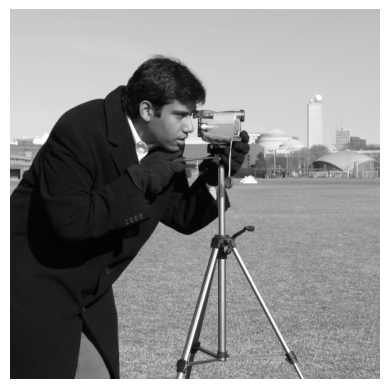

In [4]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure()
plt.imshow(camera.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

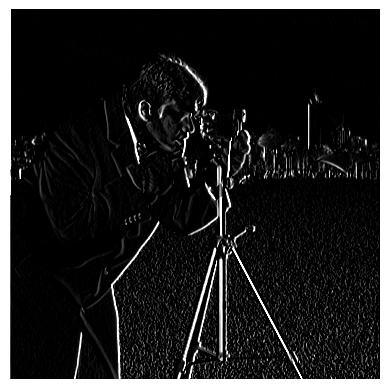

In [6]:
sobel_vert = conv(camera, sobel_kernel_vert)
plt.imshow(sobel_vert.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

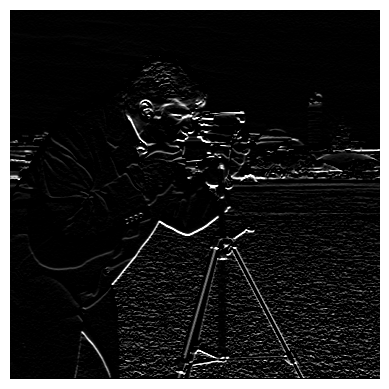

In [7]:
sobel_hor = conv(camera, sobel_kernel_hor)
plt.imshow(sobel_hor.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

Допишите код ниже и проинтерпретируйте полученный результат:

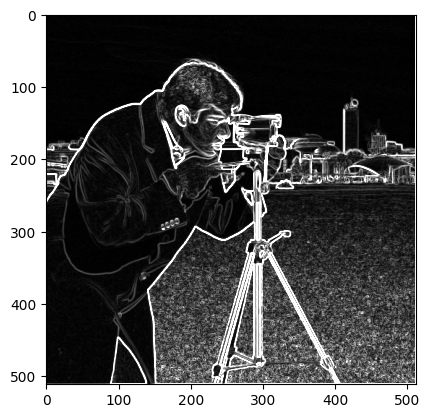

In [8]:
camera_s_hor_filter = sobel_vert
camera_s_vert_filter = sobel_hor
camera_with_borders = np.sqrt(camera_s_hor_filter**2 + camera_s_vert_filter**2)
plt.imshow(camera_with_borders, cmap="gray", vmin=0, vmax=255);

#### Получился фильтр, распознающий контуры (границы) объектов

## Задание 2. AlexNet

**15 баллов**

Воссоздайте архитектуру `AlexNet` для определения заболевания растения. Датасеты уже созданы ниже.

In [33]:
INPUT_IMAGE_SIZE = 227
BATCH_SIZE = 64
N_EPOCHS = 12 # можно будет при желании увеличить
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
from IPython.display import clear_output

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, ToPILImage
from torchvision.transforms import Normalize, Resize

from glob import glob
from torch import nn
from torch.nn import functional as F
import torch
import os

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [11]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

clear_output()

In [12]:
!unzip train.zip
!unzip validation.zip
!unzip test.zip

clear_output()

In [35]:
class BeanDataset(Dataset):
    def __init__(self, img_dir, side_size=INPUT_IMAGE_SIZE):
        # папка с картинками
        self.img_dir = img_dir
        # отсортированный список с названиями файлов
        self.files = sorted(glob(f'{img_dir}/*/*.jpg'))
        class_names = sorted(os.listdir(img_dir))
        # названия папок с картинками переведем в номера классов
        self.class_dir = {name:idx for idx, name in enumerate(class_names)}
        self._number_to_labels = {idx:name for idx, name in enumerate(class_names)}

        # трансформации данных: мы изменяем размер,
        # так как AlexNet работает с картинками 227 на 227 пикселей
        self.transforms = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor(),
                                  Normalize(
                                      mean = [0.5183, 0.4845, 0.6570],
                                      std = [0.2111, 0.2227, 0.2291]
                                  )])
        self._transforms_for_plot = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor()
                                  ])


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, normalize=True):
        file_path = self.files[idx]
        image = read_image(file_path).type(torch.DoubleTensor)

        # применяем трансформации
        if normalize:
            transformed_img = self.transforms(image)

        transformed_img = self._transforms_for_plot(image)

        label_name = file_path.split('/')[-2]
        label = self.class_dir[label_name]

        # как обычно возвращаем картинку и номер класса
        return transformed_img, label

In [36]:
train_dataset = BeanDataset("./train/")
valid_dataset = BeanDataset("./validation/")
test_dataset = BeanDataset("./test/")

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Посмотрим на наши картинки:

(код довольно эзотерический, но у меня было такое настроение)

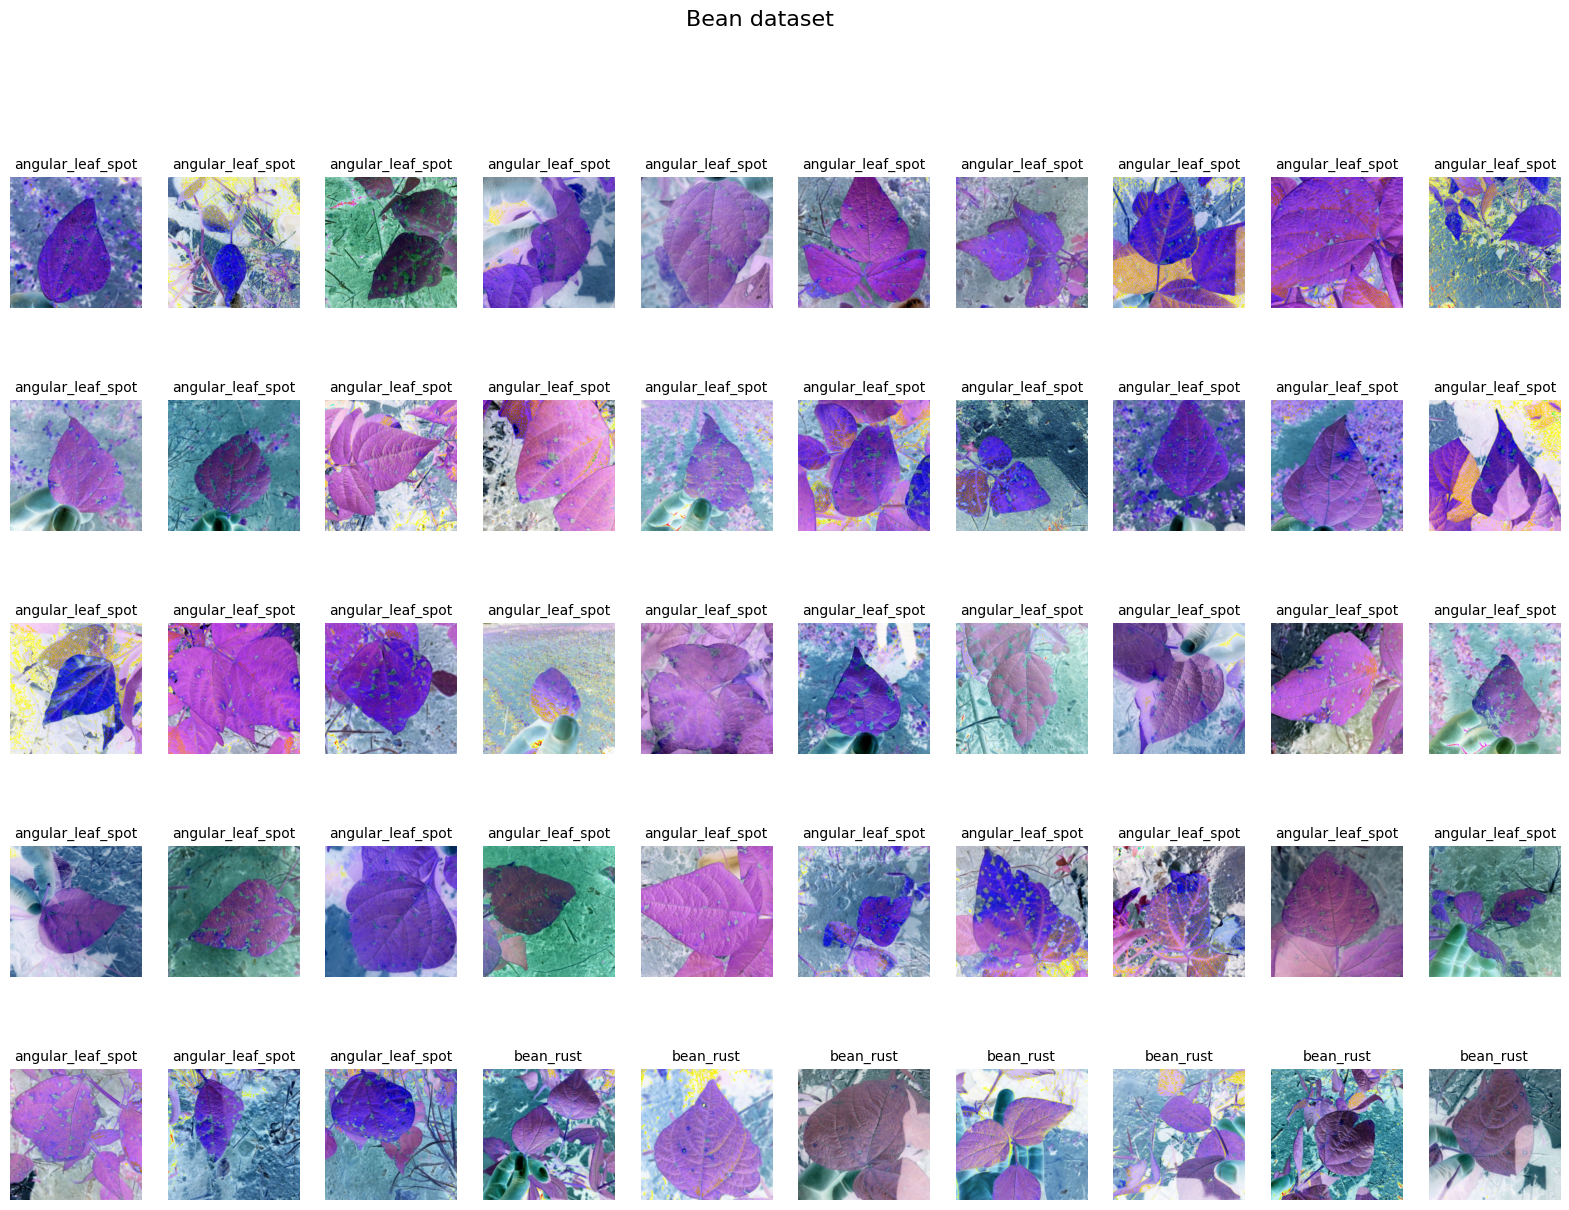

In [37]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    title = valid_dataset._number_to_labels[valid_dataset.__getitem__(index, normalize=False)[1]]
    plt.title(title, fontsize=10)

fig.suptitle("Bean dataset", fontsize=16);

### Реализация `AlexNet`

В лекции мы познакомились с архитектурой `AlexNet`, теперь пришло время реализовать ее самостоятельно. Важно, что на выходе число классов у нас будет сильно меньше чем 1000, нужно будет в начале это определить. Везде в качестве активации используется `ReLU`.

Также обратите внимание на параметры пулинга, тут ядро 3х3 со страйдом 2 (поэтому он называется overlapping).

Картинка может немного отличаться от того, что было на лекции, ориентируйтесь на картинку в ноутбуке.

Внимательно смотрите на параметры сверток (например, padding / stride).

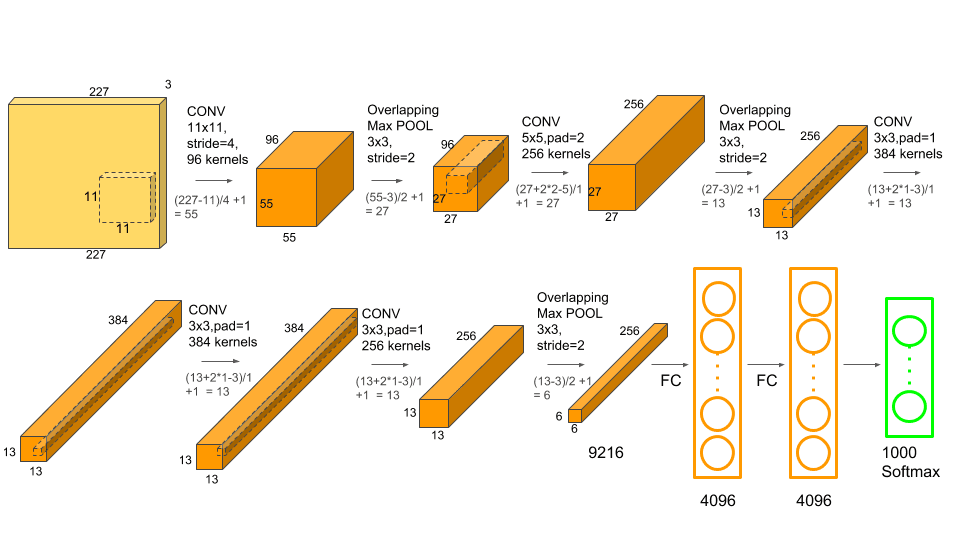

In [38]:
N_CLASSES = 3
LEARNING_RATE = 2.2e-4 # можно подобрать как-то другой)

In [39]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),
          nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),
          nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
        nn.Linear(in_features=9216, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=3)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)

        return logits, probs

Возьмите код для обучения и валидации модели, который был на лекции (если захочется, то его можно как угодно менять). В лекции мы возвращали из модели помимо логитов еще и вероятности классов, чтобы потом рисовать красивые картинки. Если захотите сделать также, то учтите это.

In [40]:
import torch.optim.lr_scheduler as lr_scheduler

In [41]:
def train_epoch(train_loader, model, criterion, optimizer, device, scheduler=None):
    """
    Function for the training step of the training loop
    """

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader, model, criterion, device):
    """
    Function for the validation step of the training loop
    """

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss


def get_accuracy(model, dataloader, device):
    """
    model -
    dataloader -
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy


def plot_losses(train_losses, valid_losses):
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, scheduler, print_every=1):
    """
    Function defining the entire training loop
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            
            if scheduler:
                scheduler.step(valid_loss)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, train_losses, valid_losses

Выберите функцию потерь и оптимизатор и обучите полученную модель на тренировочных данных, параллельно проверяя ее на валидационной части:

In [19]:
model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

22:14:07 --- Epoch: 0	Train loss: 1.1007	Valid loss: 1.0975	Train accuracy: 34.91	Valid accuracy: 33.83
22:14:30 --- Epoch: 1	Train loss: 1.0794	Valid loss: 2.0186	Train accuracy: 36.56	Valid accuracy: 39.10
22:14:53 --- Epoch: 2	Train loss: 1.1658	Valid loss: 1.0975	Train accuracy: 33.37	Valid accuracy: 33.08
22:15:16 --- Epoch: 3	Train loss: 1.0792	Valid loss: 1.0068	Train accuracy: 48.07	Valid accuracy: 48.87
22:15:38 --- Epoch: 4	Train loss: 0.9563	Valid loss: 0.8180	Train accuracy: 54.74	Valid accuracy: 57.89
22:16:01 --- Epoch: 5	Train loss: 0.8356	Valid loss: 0.7371	Train accuracy: 69.63	Valid accuracy: 68.42
22:16:24 --- Epoch: 6	Train loss: 0.7616	Valid loss: 0.8614	Train accuracy: 64.31	Valid accuracy: 58.65
22:16:46 --- Epoch: 7	Train loss: 0.6922	Valid loss: 0.7417	Train accuracy: 68.18	Valid accuracy: 69.17
22:17:09 --- Epoch: 8	Train loss: 0.7017	Valid loss: 0.7648	Train accuracy: 68.28	Valid accuracy: 69.17
22:17:32 --- Epoch: 9	Train loss: 0.6837	Valid loss: 0.6121	Trai

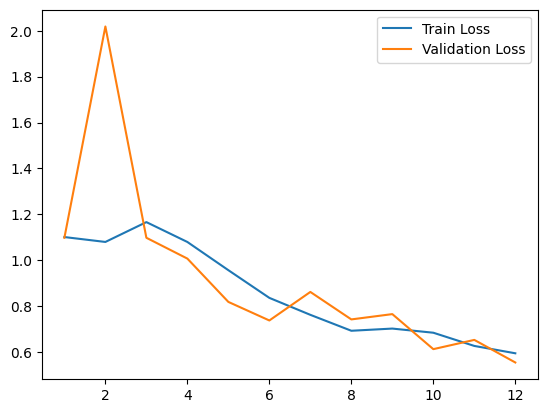

In [20]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

Если вы все реализовали правильно, то `accuracy` на валидации должна быть в районе 0.8.

#### Попробую добавить drop out

In [31]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, bias=False),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),
          nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),
          nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2),
        )
        

        self.classifier = nn.Sequential(
        nn.Linear(in_features=9216, out_features=4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=3)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)

        return logits, probs

23:23:58 --- Epoch: 0	Train loss: 1.1014	Valid loss: 1.0956	Train accuracy: 32.98	Valid accuracy: 33.08
23:24:20 --- Epoch: 1	Train loss: 1.0967	Valid loss: 1.0327	Train accuracy: 53.09	Valid accuracy: 42.86
23:24:43 --- Epoch: 2	Train loss: 1.0178	Valid loss: 0.9870	Train accuracy: 55.51	Valid accuracy: 51.88
23:25:06 --- Epoch: 3	Train loss: 0.8893	Valid loss: 0.8539	Train accuracy: 67.41	Valid accuracy: 63.91
23:25:28 --- Epoch: 4	Train loss: 0.7641	Valid loss: 1.2783	Train accuracy: 59.86	Valid accuracy: 57.14
23:25:51 --- Epoch: 5	Train loss: 0.8252	Valid loss: 0.7916	Train accuracy: 72.44	Valid accuracy: 67.67
23:26:13 --- Epoch: 6	Train loss: 0.6923	Valid loss: 0.8171	Train accuracy: 65.18	Valid accuracy: 56.39
23:26:36 --- Epoch: 7	Train loss: 0.7051	Valid loss: 0.6646	Train accuracy: 73.60	Valid accuracy: 78.95
23:26:58 --- Epoch: 8	Train loss: 0.6904	Valid loss: 0.8016	Train accuracy: 68.57	Valid accuracy: 69.17
23:27:21 --- Epoch: 9	Train loss: 0.6482	Valid loss: 0.6781	Trai

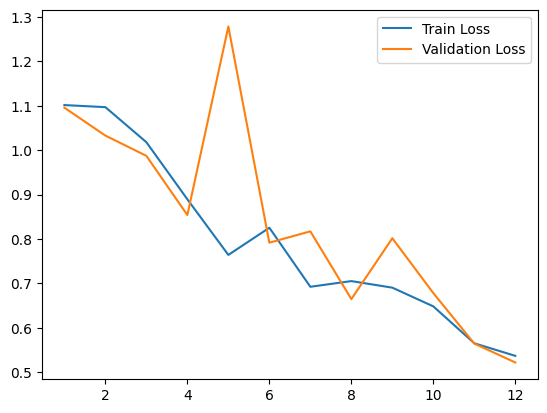

In [43]:
model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

#### Попробую увеличить количество эпох и добавить scheduler 

23:56:31 --- Epoch: 0	Train loss: 1.0887	Valid loss: 1.3449	Train accuracy: 34.33	Valid accuracy: 34.59
23:56:54 --- Epoch: 1	Train loss: 1.0981	Valid loss: 1.0308	Train accuracy: 51.74	Valid accuracy: 52.63
23:57:18 --- Epoch: 2	Train loss: 0.9146	Valid loss: 0.9006	Train accuracy: 57.06	Valid accuracy: 54.89
23:57:41 --- Epoch: 3	Train loss: 0.8228	Valid loss: 0.8339	Train accuracy: 67.41	Valid accuracy: 62.41
23:58:04 --- Epoch: 4	Train loss: 0.7352	Valid loss: 0.7729	Train accuracy: 68.57	Valid accuracy: 67.67
23:58:26 --- Epoch: 5	Train loss: 0.8322	Valid loss: 0.7367	Train accuracy: 69.73	Valid accuracy: 71.43
23:58:49 --- Epoch: 6	Train loss: 0.7618	Valid loss: 0.7587	Train accuracy: 70.89	Valid accuracy: 71.43
23:59:12 --- Epoch: 7	Train loss: 0.6617	Valid loss: 0.6050	Train accuracy: 75.24	Valid accuracy: 78.20
23:59:35 --- Epoch: 8	Train loss: 0.6600	Valid loss: 0.6202	Train accuracy: 76.40	Valid accuracy: 80.45
23:59:58 --- Epoch: 9	Train loss: 0.6676	Valid loss: 0.6211	Trai

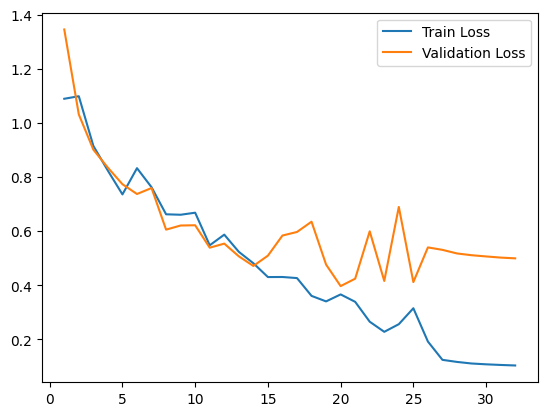

In [43]:
N_EPOCHS = 32
model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5, verbose=True, min_lr=1e-6)
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE, scheduler)

#### Переобучилась, попробую понизить число эпох

00:10:58 --- Epoch: 0	Train loss: 1.0993	Valid loss: 1.0981	Train accuracy: 36.17	Valid accuracy: 33.83
00:11:21 --- Epoch: 1	Train loss: 1.0984	Valid loss: 1.0910	Train accuracy: 35.20	Valid accuracy: 31.58
00:11:44 --- Epoch: 2	Train loss: 1.0451	Valid loss: 0.9614	Train accuracy: 53.19	Valid accuracy: 49.62
00:12:06 --- Epoch: 3	Train loss: 0.9229	Valid loss: 0.9218	Train accuracy: 56.77	Valid accuracy: 57.14
00:12:28 --- Epoch: 4	Train loss: 0.8237	Valid loss: 0.8154	Train accuracy: 67.99	Valid accuracy: 65.41
00:12:51 --- Epoch: 5	Train loss: 0.8195	Valid loss: 0.7988	Train accuracy: 67.02	Valid accuracy: 66.17
00:13:13 --- Epoch: 6	Train loss: 0.7348	Valid loss: 0.6716	Train accuracy: 72.53	Valid accuracy: 74.44
00:13:36 --- Epoch: 7	Train loss: 0.6643	Valid loss: 0.6621	Train accuracy: 74.85	Valid accuracy: 76.69
00:13:58 --- Epoch: 8	Train loss: 0.6354	Valid loss: 0.6443	Train accuracy: 74.37	Valid accuracy: 75.19
00:14:20 --- Epoch: 9	Train loss: 0.6037	Valid loss: 0.6652	Trai

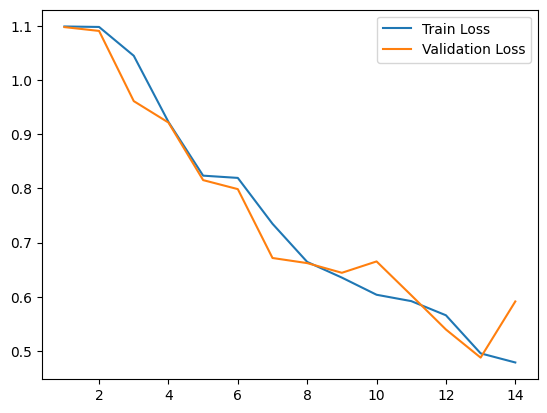

In [44]:
N_EPOCHS = 14
model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=5, verbose=True, min_lr=1e-6)
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE, scheduler)

### Визуализация предсказаний

Визуализируем предсказания нашей модели и степень уверенности в них. Сделайте выводы о качестве полученной модели.

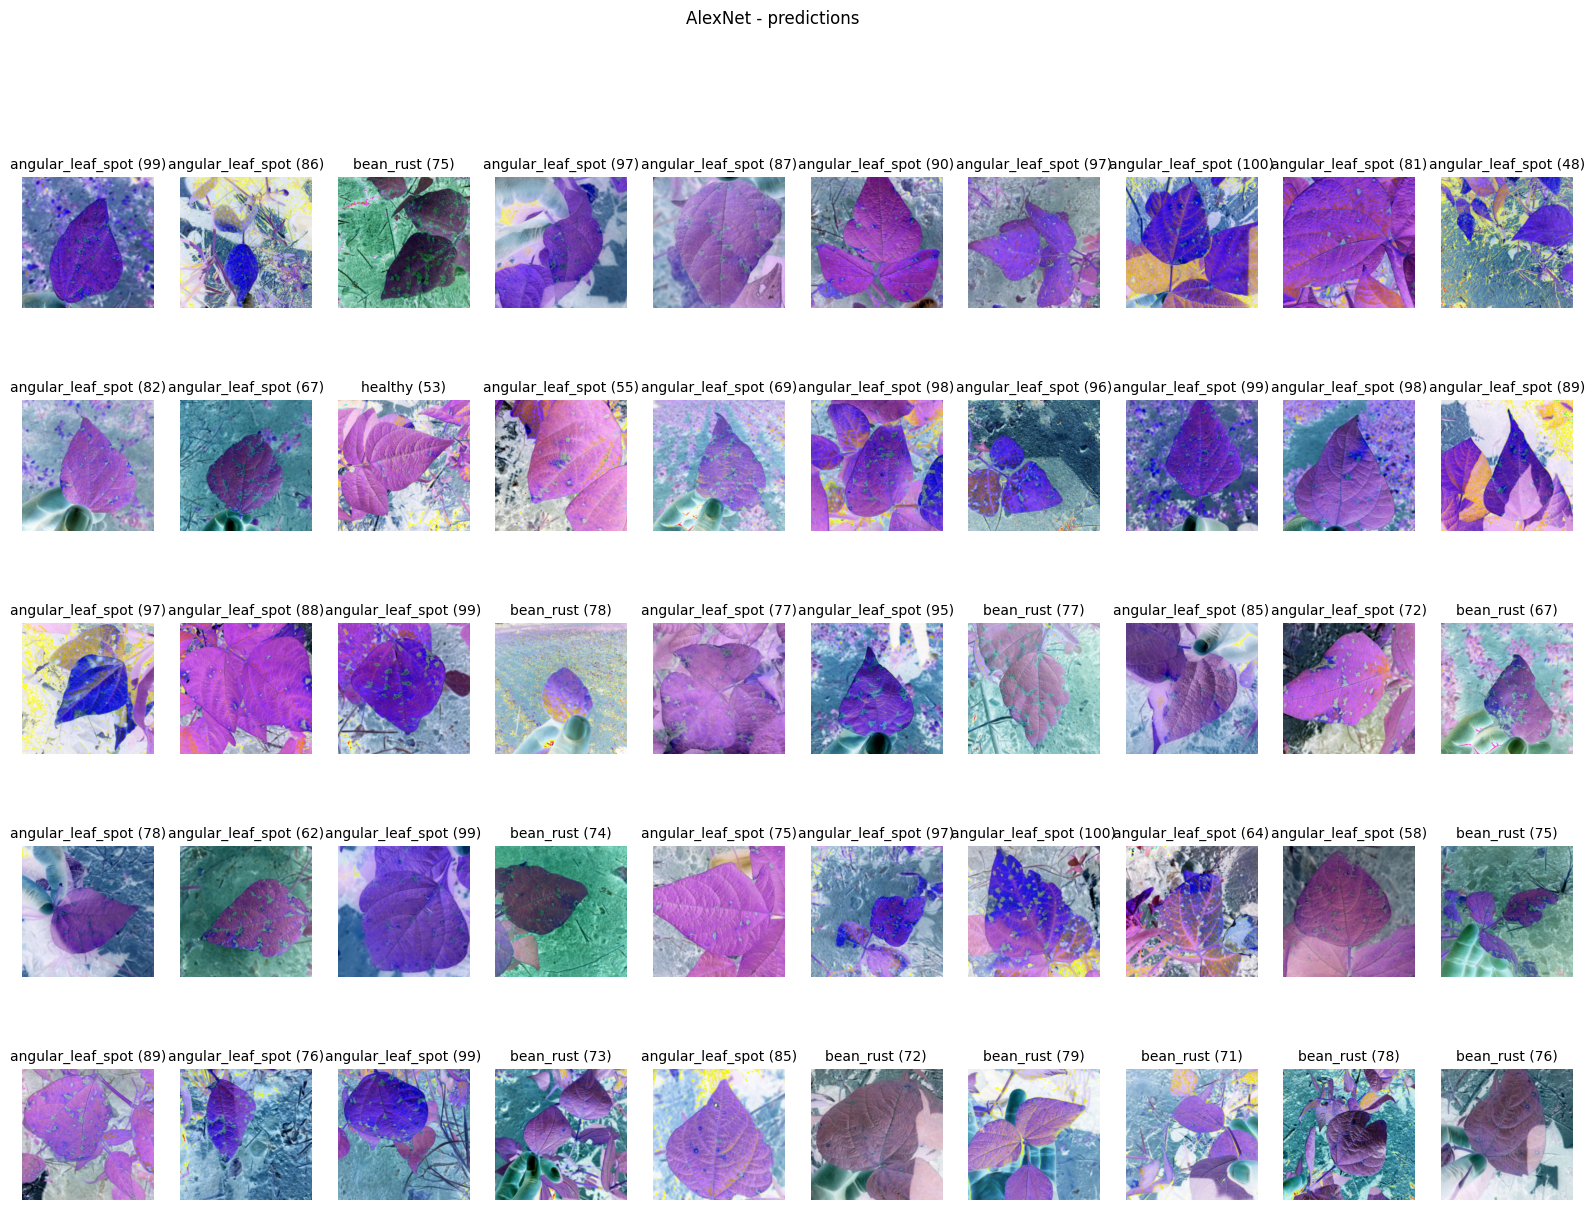

In [45]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))

    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))

    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    title = f"{valid_dataset._number_to_labels[torch.argmax(probs).item()]} ({torch.max(probs * 100):.0f})"

    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - predictions');

#### Предсказывает более меннее нормально, эксперименты с scheduler не особо повысили скор, на большом количестве эпох присутствует переобучение. 

## Задание 3. И снова социализация

**1 дополнительный балл**

Однажды такое уже бывало, но почему бы не повторить. Сходите погулять вместе с одногруппниками или созвонитесь в зуме, а сюда прикрепите какие-нибудь фотографии и кратко опишите, на какие темы вы общались)

![fig](fig/classmate.png)

Всю прогулку рассказывала моему одногруппнику смешные анекдоты.

Тут, как обычно, можно описать свои эмоции от выполнения этого задания:

**Ответ:**